# Import de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.dummy import DummyClassifier
from sklearn.metrics  import accuracy_score, classification_report, plot_confusion_matrix, SCORERS
from sklearn.metrics import fbeta_score, plot_roc_curve, make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform

from scipy import stats

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import sys
sys.path.append("../scripts/")

# Definição de funções

In [2]:
def remove_corr_var(dados, valor_corte):
    matriz_corr = dados.iloc[:,1:].corr().abs()
    matriz_upper = matriz_corr.where(np.triu(np.ones(matriz_corr.shape), k=1).astype(np.bool))
    excluir = [coluna for coluna in matriz_upper.columns if any(matriz_upper[coluna] > valor_corte)]
    
    return dados.drop(excluir, axis=1)

Essa função cria uma matriz de correlação, separa a diagonal superior e usa ela junto com a condição de corte para retornar somente um conjunto de features que não possuem alta correlação entre si.

In [63]:
def roda_modelo(modelo, dados, parametros):
    
    #Definindo colunas x e y:
    
    x = dados.drop(['inadimplente'], axis=1)
    y = dados['inadimplente']
    
    # Separando dados em treino e teste:
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=SEED)
    
    #Método de crossvalidation:
    
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3)
    
    #Otimizador de parâmetros utilizando o método de crossvalidation anterior, repetindo 100 vezes e
    #utilizando a métrica ROC AUC para determinar os melhores parâmetros.
    
    modelo_score_roc = RandomizedSearchCV(modelo, param_distributions=parametros,
                              n_iter = 100, cv = cv, scoring='roc_auc', n_jobs=5)
    
    #O mesmo, só que utilizando como métrica de otimização a precisão:
    
    modelo_score_precision = RandomizedSearchCV(modelo, param_distributions=parametros,
                              n_iter = 100, cv = cv, scoring='precision', n_jobs=5)
    print('-*-' * 38)
    print(f'Para o RandomizedSearch usando o score ROC AUC:')
    print('-*-' * 38)
    
    #Achando o modelo otimizado:
    
    modelo_score_roc.fit(x_train, y_train)
    print(f'Melhores parâmetros:')
    
    #Obtendo a lista dos parâmetros do modelo:
    
    a = modelo_score_roc.best_params_
    print(a)
    
    #Obtendo a previsão do modelo para o x_teste em porcentagem:
    
    prob_predic = modelo_score_roc.predict_proba(x_test)
    
    #Obtendo a previsão do modelo para o x_teste:

    predicao = modelo_score_roc.predict(x_test)
    print(f'Matriz de confusão:')
    
    #Plotando matriz de confusão:
    
    matriz_confusao = plot_confusion_matrix(modelo_score_roc, x_test, y_test, values_format='.0f')
    plt.grid(False)    
    plt.show(matriz_confusao)
    
    #Calculando os scores KS e ROC AUC com as previsões retiradas acima:
    
    auc = roc_auc_score(y_test, prob_predic[:,1])
    data_bom = np.sort(prob_predic[:, 1])
    data_mau = np.sort(prob_predic[:, 0])
    kstest = stats.ks_2samp(data_bom, data_mau)
    print(f"O score ROC AUC foi de {auc} e o Ks foi de : {kstest}.")
    print("\nClassification Report")
    
    #Imprimindo o classification report:
    
    print(classification_report(y_test, predicao, zero_division=0))
    
##########################################################################################################    

    print('-*-' * 38)
    print(f'Para o RandomizedSearch usando a precisão:')
    print('-*-' * 38)
    
    #Achando o modelo otimizado:
 
    modelo_score_precision.fit(x_train, y_train)
    print(f'Melhores parâmetros:')
    
    #Obtendo a lista dos parâmetros do modelo:

    a = modelo_score_precision.best_params_
    print(a)
    
    #Obtendo a previsão do modelo para o x_teste em porcentagem:
    
    prob_predic = modelo_score_precision.predict_proba(x_test)
    
    #Obtendo a previsão do modelo para o x_teste:
    
    predicao = modelo_score_precision.predict(x_test)
    print(f'Matriz de confusão:')
    
    #Plotando matriz de confusão:
    
    matriz_confusao = plot_confusion_matrix(modelo_score_precision, x_test, y_test, values_format='.0f')
    plt.grid(False)    
    plt.show(matriz_confusao) 
    
    #Calculando os scores KS e ROC AUC com as previsões retiradas acima:
 
    auc = roc_auc_score(y_test, prob_predic[:,1])
    data_bom = np.sort(prob_predic[:, 1])
    data_mau = np.sort(prob_predic[:, 0])
    kstest = stats.ks_2samp(data_bom, data_mau)
    print(f"O score ROC AUC foi de {auc} e o Ks foi de : {kstest}.")
    print("\nClassification Report")
    
    #Imprimindo o classification report:

    print(classification_report(y_test, predicao, zero_division=0))

In [4]:
def plot_confusion_matrix_for_models(names, classifiers, nrows, ncols, dados):
    # separando dados em x e y:
    
    x = dados.drop(['inadimplente'], axis=1)
    y = dados['inadimplente']
    
    # Separando dados em treino e teste:
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=SEED)
    
    #Cria os subplots

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 20))
    axis = []
    for ax in axes:
        axis.extend(ax)
    axes_ind = 0
    trained_models = []
    
    #Para cada dupla de modelo e nome imprime uma matriz de confusão, assim como pega os parâmetros necessários
    #para imprimir também o valor do AUC e KS Score de cada modelo:
    
    for name, clf in zip(names, classifiers):
        
        #Definindo o modelo utilizando o pipeline junto com a função SMOTE:
        
        pipeline = Pipeline([('sampling', SMOTE(random_state=SEED)),
                             ('Modelo', clf)])   
        
        #Treinando o modelo:
        
        pipeline.fit(x_train, y_train)
        
        #Definindo a matriz de confusão em uma variável:
        
        disp = plot_confusion_matrix(pipeline, x_test, y_test, ax=axis[axes_ind])
        
        #Previsão do modelo:
        
        y_predict = pipeline.predict(x_test)
        prob_predic = pipeline.predict_proba(x_test)
        
        #Obtendo as métricas através das previsões:
        
        auc = roc_auc_score(y_test, prob_predic[:,1])
        data_bom = np.sort(prob_predic[:, 1])
        data_mau = np.sort(prob_predic[:, 0])
        kstest = stats.ks_2samp(data_bom, data_mau)
        
        #Iprimindo como título da matriz de confusão deste modelo seu nome e suas métricas:
        
        axis[axes_ind].set_title(f'{name}, AUC = {auc:.2f}, KS = {kstest[0]}')
        axes_ind += 1
    plt.show()
    for ax in axis[len(names):]:
        ax.set_visible(False)
        fig.delaxes(ax)

# Import dos dados

In [5]:
df_treino = pd.read_csv("treino.csv")
df_treino

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
109995,0,0.137396,59,1,0.448912,9600.0,10,0,2,0,0.0
109996,0,0.276964,46,0,0.491288,12224.0,19,0,4,0,4.0
109997,0,0.181257,43,0,0.382635,12000.0,13,0,2,0,2.0
109998,0,0.037699,86,0,0.248107,7000.0,14,0,2,0,1.0


In [6]:
df_teste = pd.read_csv("teste.csv")
df_teste

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
39995,0.000000,68,1,0.062858,10833.0,9,1,0,0,0.0
39996,0.061117,84,0,0.013598,8456.0,7,0,0,0,0.0
39997,0.817745,70,0,0.663056,6000.0,17,0,2,0,0.0
39998,0.106139,64,2,0.865438,5045.0,12,0,4,0,0.0


# Análise exploratória e Tratamento de Dados

In [7]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 11 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   inadimplente                           110000 non-null  int64  
 1   util_linhas_inseguras                  110000 non-null  float64
 2   idade                                  110000 non-null  int64  
 3   vezes_passou_de_30_59_dias             110000 non-null  int64  
 4   razao_debito                           110000 non-null  float64
 5   salario_mensal                         88237 non-null   float64
 6   numero_linhas_crdto_aberto             110000 non-null  int64  
 7   numero_vezes_passou_90_dias            110000 non-null  int64  
 8   numero_emprestimos_imobiliarios        110000 non-null  int64  
 9   numero_de_vezes_que_passou_60_89_dias  110000 non-null  int64  
 10  numero_de_dependentes                  107122 non-null  

Pela análise do .info podemos ver que as features de salario_mensal e numero_de_dependentes possuem valores faltantes, assim devemos aplicar alguma técnica para preencher esses valores.

In [8]:
df_treino.describe()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,8.823700e+04,110000.000000,110000.000000,110000.000000,110000.000000,107122.000000
mean,0.066645,5.929979,52.255636,0.424055,354.823589,6.637411e+03,8.445573,0.269955,1.019891,0.243891,0.757482
std,0.249408,252.301965,14.768241,4.240780,2074.140421,1.338395e+04,5.139026,4.217326,1.135989,4.204137,1.114670
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030054,41.000000,0.000000,0.175016,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.155936,52.000000,0.000000,0.366682,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.562806,63.000000,0.000000,0.866874,8.225000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Conseguimos observar que, com exceção da variável inadimplente, todas as outras possuem outliers que estão distorcendo suas quantidades estatísticas, assim, se faz necessário a retirada desses outliers para conseguirmos treinar um algoritmo mais generalista assim como melhor preenchermos os valores faltantes nas duas features previamente citadas.

Aqui irei retirar os clientes que possuirem valores para essas features acima ou abaixo de dois desvios padrão. Para algumas features esse método parece ser bem apropriado, como linhas de crédito abertas e número de dependentes, contudo, para outras features como idade e razão_debito será necessário olhar mais de perto para ver o quão apropriada essa técnica seria.

<AxesSubplot:>

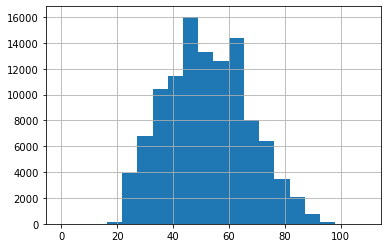

In [9]:
df_treino['idade'].hist(bins=20)

In [10]:
idade_mean = df_treino.idade.mean()

idade_std = df_treino.idade.std()

In [11]:
corte_idade = df_treino.query('(@idade_mean - 2 * @idade_std) < idade < (@idade_mean + 2 * @idade_std)')['idade']

corte_idade.shape

(106521,)

<AxesSubplot:>

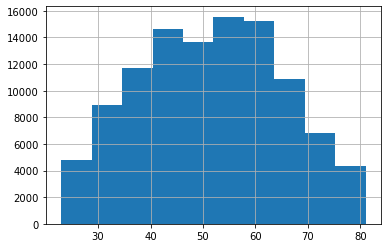

In [12]:
corte_idade.hist()

Vemos que para a variável idade essa análise preserva a maior parte dos dados e retira os outliers, deixando ainda um recorte de faixa etária bem plausível com a realidade para a análise, assim, se classificando como um método adequado para exclusão de outliers para esta feature.

In [13]:
df_treino['razao_debito'].quantile(0.80)

3.94226015280005

In [14]:
df_treino['razao_debito'].quantile(0.85)

263.0

In [15]:
df_treino['razao_debito'].quantile(0.90)

1265.0

In [16]:
df_treino['razao_debito'].quantile(0.95)

2464.0499999999884

In [17]:
df_treino['razao_debito'].quantile(0.99)

5000.009999999995

<AxesSubplot:>

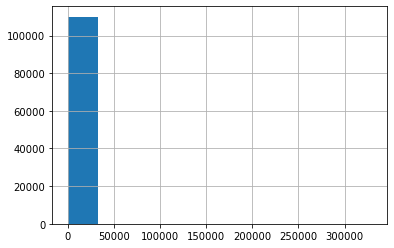

In [18]:
df_treino['razao_debito'].hist()

In [19]:
razao_mean = df_treino.razao_debito.mean()

razao_std = df_treino.razao_debito.std()

<AxesSubplot:>

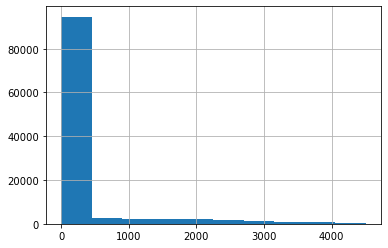

In [20]:
corte_razao_debito = df_treino.query('(@razao_mean - 2 * @razao_std) < razao_debito < (@razao_mean + 2 * @razao_std)')

corte_razao_debito['razao_debito'].hist()

In [21]:
corte_razao_debito.shape

(108532, 11)

Conseguimos ver que claramente os outliers deformam o primeiro histograma plotado e que aplicado o corte sugerido é preservado uma grande quantidade dos nossos clientes, contudo, temos valores não desprezíveis de clientes com uma razão débito muito grande ainda.

Essa variável se torna problemática pois é dada pela divisão:

$$razao = (divida)/(patrimonio) $$

E não sabemos explicitamente o valor das dívidas dos clientes nem de seus patrimônions, logo, essa grande quantidade de  clientes que possui dívidas muito maiores que seu patrimônio pode se dar pelo valor baixo de seus patrimônios, onde podemos ter clientes com patrimônios quase nulos, ou pois eles se individaram de forma absurda.

Utilizando a função quatile, pude cosntatar que 10% dos clientes tem essa razão débito maior que 1265. Assim, se um desses clientes, por exemplo, tivesse de patrimônio apenas uma moto de, digamos, R$15.000, sua dívida seria de aproximadamente 19 milhões, logo, é muito improvável que essa seja a realidade da maioria desses clientes. Concluindo, a maioria desses clientes com uma razão débito "alta" (>>1) seriam clientes que possuem poucos ou quase nenhum patrimônio declarado, logo, uma boa forma de avaliar esta variável seria usar a variável patrimônio para definir quais desses clientes são outliers ou só clientes com poucos patrimônios declarados, ou de forma semelhante a própria variável de dívida. Como não as possuimos poderiamos tentar correlacionar algumas das variáveis que temos com elas, para assim, fazer um bom recorte de outliers para esta feature, por exemplo, usando a feature salário tendo em mente que ela estaria correlacionada com o patrimônio ou a feature número de empréstimos imobiliários pensando que esta poderia estar correlacionada com a dívida.

In [22]:
matriz_corr = df_treino.corr().abs()

matriz_corr

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
inadimplente,1.000000,0.003263,0.114281,0.124546,0.006534,0.020271,0.029332,0.116023,0.008144,0.101536,0.043079
util_linhas_inseguras,0.003263,1.000000,0.004444,0.001336,0.001255,0.008203,0.010120,0.001154,0.007590,0.001105,0.000986
idade,0.114281,0.004444,1.000000,0.063230,0.025221,0.040922,0.148640,0.061371,0.032920,0.057604,0.212194
vezes_passou_de_30_59_dias,0.124546,0.001336,0.063230,1.000000,0.006860,0.010939,0.056347,0.984157,0.031093,0.987377,0.003183
razao_debito,0.006534,0.001255,0.025221,0.006860,1.000000,0.033734,0.047158,0.008344,0.117054,0.007558,0.042631
salario_mensal,0.020271,0.008203,0.040922,0.010939,0.033734,1.000000,0.096490,0.013725,0.133508,0.012404,0.066444
numero_linhas_crdto_aberto,0.029332,0.010120,0.148640,0.056347,0.047158,0.096490,1.000000,0.080873,0.433337,0.071979,0.065191
numero_vezes_passou_90_dias,0.116023,0.001154,0.061371,0.984157,0.008344,0.013725,0.080873,1.000000,0.045902,0.993162,0.011052
numero_emprestimos_imobiliarios,0.008144,0.007590,0.032920,0.031093,0.117054,0.133508,0.433337,0.045902,1.000000,0.039987,0.122481
numero_de_vezes_que_passou_60_89_dias,0.101536,0.001105,0.057604,0.987377,0.007558,0.012404,0.071979,0.993162,0.039987,1.000000,0.011660


Dado que nenhuma outra feature apresentou uma boa correlação com a feature razao_debito irei prosseguir com o mesmo processo de exclusão de outliers para todas as features pois assumirei que a maioria dos clientes com uma razão débito alta, que restarão após a exclusão dos com que pussuirem $razao > media + 2*desvio$ representam clientes que possuem poucos ou nenhum patrimônio declarado, assim, representando a realidade. 

Não estou negando a possível existência de outliers dentro dessa amostra que restará após essa remoção, ainda mais na feature razao_debito, mas que a quantidade deles será ínfima, não alterando substancialmente nossas análises daqui para frente.

In [23]:
df_sem_outliers = df_treino

for x in range(1, len(df_sem_outliers.columns)):
    
    dropar = []
    
    qntd_linhas = df_sem_outliers.shape[0]
    
    media = df_sem_outliers.iloc[:,x].mean()
    
    desvio = df_sem_outliers.iloc[:,x].std()
    
    for i in range(0,qntd_linhas):
        
        if df_sem_outliers.iloc[i,x] > (media + 2 * desvio) or df_sem_outliers.iloc[i,x] < (media - 2 * desvio):
        
            dropar.append(i)
    
    df_sem_outliers = df_sem_outliers.drop(dropar)
    df_sem_outliers = df_sem_outliers.reset_index().drop(['index'], axis=1)
            
df_sem_outliers

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
1,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
2,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
3,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
4,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
80562,0,0.102095,59,0,2389.000000,NaN,6,0,1,0,0.0
80563,0,0.148856,29,0,35.000000,NaN,2,0,0,0,0.0
80564,0,0.137396,59,1,0.448912,9600.0,10,0,2,0,0.0
80565,0,0.181257,43,0,0.382635,12000.0,13,0,2,0,2.0


In [24]:
80567/110000

0.7324272727272727

Feita a remoção das linhas que continham possíveis outliers terminamos com 80567 linhas, aproximadamente 73% do total de dados.

In [25]:
matriz_corr2 = df_sem_outliers.corr().abs()

matriz_corr2

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
inadimplente,1.000000,0.021000,0.095610,0.206271,0.022525,0.046856,0.015051,0.206146,0.032491,NaN,0.026201
util_linhas_inseguras,0.021000,1.000000,0.025528,0.016003,0.005748,0.008800,0.023809,0.018939,0.015074,NaN,0.000723
idade,0.095610,0.025528,1.000000,0.066714,0.044948,0.134881,0.156622,0.062334,0.060169,NaN,0.169471
vezes_passou_de_30_59_dias,0.206271,0.016003,0.066714,1.000000,0.012468,0.002494,0.080735,0.155080,0.021792,NaN,0.055858
razao_debito,0.022525,0.005748,0.044948,0.012468,1.000000,0.146111,0.052465,0.025512,0.195237,NaN,0.097677
salario_mensal,0.046856,0.008800,0.134881,0.002494,0.146111,1.000000,0.228398,0.043780,0.295128,NaN,0.151923
numero_linhas_crdto_aberto,0.015051,0.023809,0.156622,0.080735,0.052465,0.228398,1.000000,0.080280,0.393594,NaN,0.090807
numero_vezes_passou_90_dias,0.206146,0.018939,0.062334,0.155080,0.025512,0.043780,0.080280,1.000000,0.065589,NaN,0.008805
numero_emprestimos_imobiliarios,0.032491,0.015074,0.060169,0.021792,0.195237,0.295128,0.393594,0.065589,1.000000,NaN,0.149569
numero_de_vezes_que_passou_60_89_dias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mesmo após essa análise vemos que a feature razao_debito não pussui correlação significativa com nenhuma das outras features.

Feita a remoção de outliers, podemos agora tratar dos valores faltantes.

In [26]:
df_sem_outliers.describe()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,80567.000000,80567.000000,80567.000000,80567.000000,80567.000000,63998.000000,80567.000000,80567.000000,80567.000000,80567.0,78360.000000
mean,0.043517,0.350879,52.025420,0.177591,275.608968,5884.124707,7.661698,0.029441,0.815607,0.0,0.491322
std,0.204018,3.931442,14.324327,0.549591,753.696034,3907.745303,4.045930,0.169041,0.763078,0.0,0.736480
min,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.026893,41.000000,0.000000,0.162712,3219.000000,5.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.132098,52.000000,0.000000,0.347844,5000.000000,7.000000,0.000000,1.000000,0.0,0.000000
75%,0.000000,0.501835,63.000000,0.000000,0.865826,7671.750000,10.000000,0.000000,1.000000,0.0,1.000000
max,1.000000,502.000000,81.000000,8.000000,4555.000000,33333.000000,18.000000,1.000000,2.000000,0.0,2.000000


Como já dito somenta as features salario_mensal e numero_de_dependentes possuem valores faltantes. Irei substituir esses valores faltantes pelo valor médio. Agora que os outliers são menos preponderantes na base de dados a substituição pelo valor médio atual é mais acurada.

In [27]:
valores_replace = {'salario_mensal':df_sem_outliers['salario_mensal'].mean(),
                  'numero_de_dependentes':df_sem_outliers['numero_de_dependentes'].mean()}

In [28]:
df_sem_outliers_sem_nan = df_sem_outliers.fillna(value=valores_replace)

In [29]:
df_sem_outliers_sem_nan.describe()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,80567.000000,80567.000000,80567.000000,80567.000000,80567.000000,80567.000000,80567.000000,80567.000000,80567.000000,80567.0,80567.000000
mean,0.043517,0.350879,52.025420,0.177591,275.608968,5884.124707,7.661698,0.029441,0.815607,0.0,0.491322
std,0.204018,3.931442,14.324327,0.549591,753.696034,3482.812999,4.045930,0.169041,0.763078,0.0,0.726322
min,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.026893,41.000000,0.000000,0.162712,3711.000000,5.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.132098,52.000000,0.000000,0.347844,5884.124707,7.000000,0.000000,1.000000,0.0,0.000000
75%,0.000000,0.501835,63.000000,0.000000,0.865826,6850.000000,10.000000,0.000000,1.000000,0.0,1.000000
max,1.000000,502.000000,81.000000,8.000000,4555.000000,33333.000000,18.000000,1.000000,2.000000,0.0,2.000000


Com os valores vazios agora preenchidos o último tratamento que irei fazer será retirar colunas irrelevantes, ou seja, calculando a correlação entre todas as features e dentre as que tiverem alta correlação entre si irei deixar somente uma representante.

Para isso utilizarei a função remove_corr_var irei passar um valor de corte que determinará qual será o nível de correlação mínimo para remover as features. A função basicamente cria uma uma matriz de correlação, previamente já usada, separa a diagonal superior dela somente e depois percorre cada valor de correlação a fim de excluir uma feature de um par de features que tenha correlação maior que o valor de corte.

In [30]:
df_sem_corr_nan_outlier = remove_corr_var(df_sem_outliers_sem_nan, 0.85)
df_sem_corr_nan_outlier

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0,0.957151,40,0,0.121876,2600.000000,4,0,0,0,1.0
1,0,0.658180,38,1,0.085113,3042.000000,2,1,0,0,0.0
2,0,0.233810,30,0,0.036050,3300.000000,5,0,0,0,0.0
3,0,0.213179,74,0,0.375607,3500.000000,3,0,1,0,1.0
4,0,0.754464,39,0,0.209940,3500.000000,8,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
80562,0,0.102095,59,0,2389.000000,5884.124707,6,0,1,0,0.0
80563,0,0.148856,29,0,35.000000,5884.124707,2,0,0,0,0.0
80564,0,0.137396,59,1,0.448912,9600.000000,10,0,2,0,0.0
80565,0,0.181257,43,0,0.382635,12000.000000,13,0,2,0,2.0


In [31]:
df_sem_corr_nan_outlier.shape

(80567, 11)

In [32]:
df_sem_outliers_sem_nan.shape

(80567, 11)

Sendo assim nosso dataframe final será o df_sem_corr_nan_outlier, que é igual ao anterior pois nenhuma feature foi retirada, contudo, ressalta a importância desta etapa no processo.

O último passo é verificar se eles está desbalanceado.

In [33]:
df_sem_corr_nan_outlier['inadimplente'].value_counts(normalize=True)

0    0.956483
1    0.043517
Name: inadimplente, dtype: float64

Dado que os dados estão bem desbalanceados teremos que aplicar uma técnica para corrigir isso ao treinar o modelo.

In [34]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   util_linhas_inseguras                  40000 non-null  float64
 1   idade                                  40000 non-null  int64  
 2   vezes_passou_de_30_59_dias             40000 non-null  int64  
 3   razao_debito                           40000 non-null  float64
 4   salario_mensal                         32032 non-null  float64
 5   numero_linhas_crdto_aberto             40000 non-null  int64  
 6   numero_vezes_passou_90_dias            40000 non-null  int64  
 7   numero_emprestimos_imobiliarios        40000 non-null  int64  
 8   numero_de_vezes_que_passou_60_89_dias  40000 non-null  int64  
 9   numero_de_dependentes                  38954 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 3.1 MB


In [35]:
df_teste.describe()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,40000.000000,40000.000000,40000.000000,40000.000000,3.203200e+04,40000.000000,40000.000000,40000.000000,40000.000000,38954.000000
mean,6.374199,52.404025,0.412725,348.004166,6.760602e+03,8.472525,0.255025,1.013700,0.230750,0.756508
std,242.617247,14.781468,4.057899,1934.436246,1.683639e+04,5.164960,4.034327,1.112494,4.017506,1.116244
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029362,41.000000,0.000000,0.175360,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.149491,52.000000,0.000000,0.366172,5.409500e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.549762,63.000000,0.000000,0.872253,8.284000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,22000.000000,109.000000,98.000000,307001.000000,1.794060e+06,57.000000,98.000000,25.000000,98.000000,13.000000


Podemos notar que nosso dataframe de teste está permeado de valor extremos e valores faltantes, contudo, o único tratamento que darei para ele será o de excluir as linhas com valores faltantes, deixando aquelas com valores extremos ainda para teste pois no máximo teremos uma previsão errada para os mesmos, não é como o treinamento do modelo onde a capacidade de previsão e generalização do mesmo é altamente alterada por esses outliers.

In [36]:
df_teste_sem_nan = df_teste.dropna()

In [37]:
df_teste_sem_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32032 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   util_linhas_inseguras                  32032 non-null  float64
 1   idade                                  32032 non-null  int64  
 2   vezes_passou_de_30_59_dias             32032 non-null  int64  
 3   razao_debito                           32032 non-null  float64
 4   salario_mensal                         32032 non-null  float64
 5   numero_linhas_crdto_aberto             32032 non-null  int64  
 6   numero_vezes_passou_90_dias            32032 non-null  int64  
 7   numero_emprestimos_imobiliarios        32032 non-null  int64  
 8   numero_de_vezes_que_passou_60_89_dias  32032 non-null  int64  
 9   numero_de_dependentes                  32032 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 2.7 MB


Para o dataframe de teste acabamos perdendo 20% das linhas, contudo, ainda há considerável material para teste.

# Definição e treinamento dos Modelos de Machine Learning

 Irei aqui utilizar as métricas de Curva ROC AUC, uma métrica que calcula a área abaixo da curva ROC e quanto maior mais balanceado e altos estão seus índices de verdadeiro positivo e verdadeiro negativo, e também o KS Score, uma métrica muito utilizada neste problema de crédito bancário e que mede a maior distância entre a distribuição esperada e a prevista, quanto maior melhor. Aliado a essas duas métricas também utilizarei matrizes de confusão para ter um panorama mais geral de cada modelo.
 
 Primeiramente testarei uma gama de modelos de classificassão e prosseguirei com os que obtiverem melhores resultados para uma otimização de hiperparâmetros afim de obter resultados mais refinados.
 
 Um detalhe muito importante nesta análise toda é que eu utilizarei o pipeline em conjunto com a função SMOTE. O SMOTE tem como finalidade resolver o problema de desbalanceamento dos dados que evidenciamos acima, criando mais dados referentes à categoria desbalanceada para treinar o modelo.

In [38]:
SEED = 9123759

In [39]:
names = ["K Neighbors",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "GBC"]

In [40]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=100),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
]

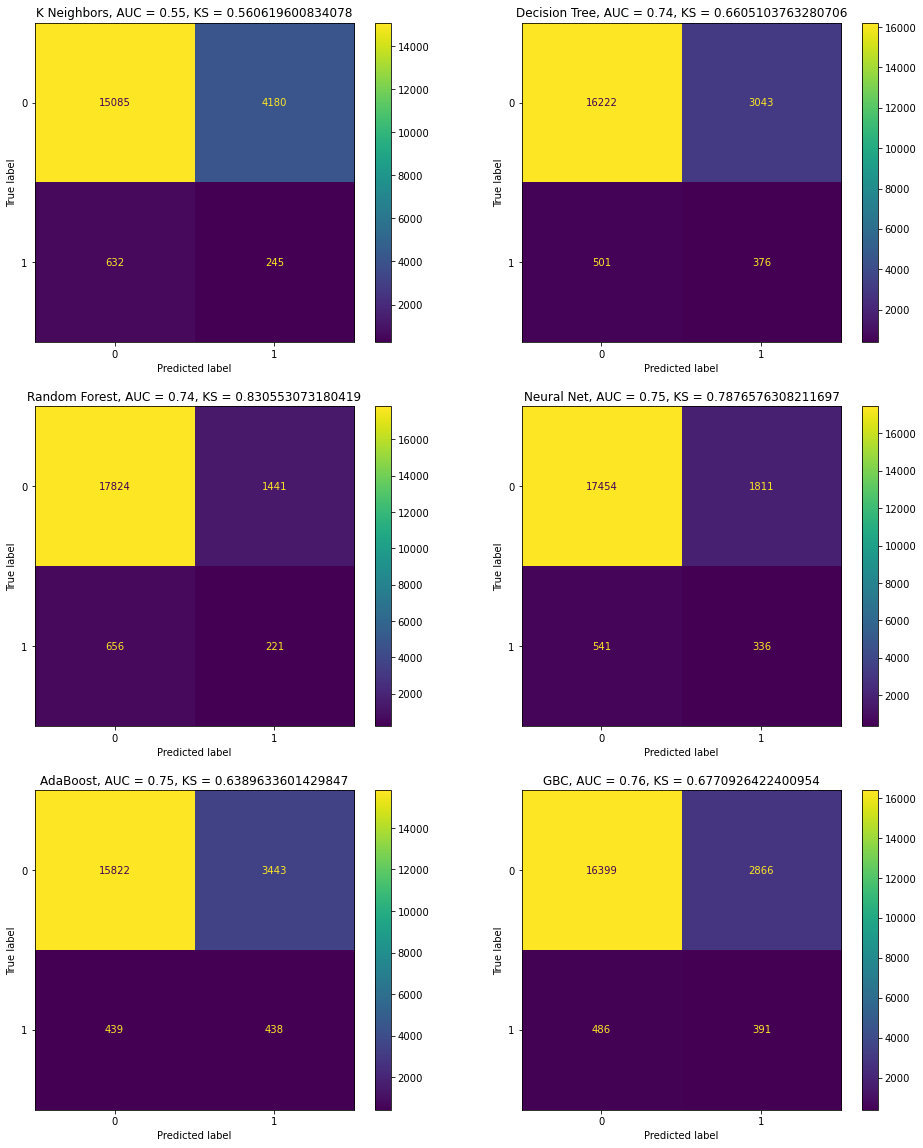

In [61]:
_ = plot_confusion_matrix_for_models(names,classifiers , 3, 2, df_sem_corr_nan_outlier)

Feita essa análise, dois modelos se sobressairam : RandomForestClassifier e MLPClassifier obtiveram os melhores métricas ROC AUC e KS Score, assim como os maiores números de Verdadeiros positivo e negativo, assim como os menores números de Falsos positivo e negativo.

Irei seguir a análise com esses dois modelos, fazendo uma otimização dos hiperparâmetros, buscando qual é a melhor parametrização para que o modelo resulte nos melhores resultados através de 2 métricas: Roc AUC Score e Precisão. Eu utilizei a precisão como métricas a ser passada para o RandomizedSearchCV pois ele não admite a métrica de KS. Dentre as disponíveis eu escolhi a métrica de precisão para assim treinar 2 modelos, cada um otimizado com uma das métricas citadas, a fim de ver qual deles obteria o melhor resultado. A métrica de precisão não é uma boa escolha tendo em vista que nosso problema sucinta um maior foco na precisão de Verdadeiros positivos, contudo, foi só uma opção a mais na análise.

In [61]:
modelo_forest = Pipeline([('sampling', SMOTE(random_state=SEED)),
                             ('Modelo', RandomForestClassifier(random_state=SEED))]) 
forest_parametros = {
    "Modelo__n_estimators" : sp_randInt(100, 1000),
    "Modelo__max_depth" : sp_randInt(1, 10),
    "Modelo__min_samples_leaf" : sp_randInt(1, 200),
    "Modelo__min_samples_split" : sp_randInt(2, 200),
    "Modelo__bootstrap" : [True, False]
}

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Para o RandomizedSearch usando o score ROC AUC:
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Melhores parâmetros:
{'Modelo__bootstrap': True, 'Modelo__max_depth': 9, 'Modelo__min_samples_leaf': 196, 'Modelo__min_samples_split': 130, 'Modelo__n_estimators': 818}
Matriz de confusão:


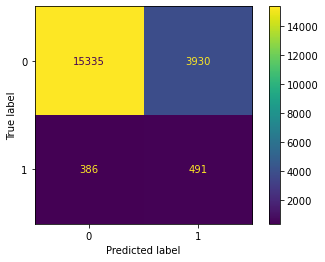

O score ROC AUC foi de 0.7685394934303142 e o Ks foi de : KstestResult(statistic=0.5625558534405719, pvalue=0.0).

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     19265
           1       0.11      0.56      0.19       877

    accuracy                           0.79     20142
   macro avg       0.54      0.68      0.53     20142
weighted avg       0.94      0.79      0.85     20142

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Para o RandomizedSearch usando a precisão:
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Melhores parâmetros:
{'Modelo__bootstrap': True, 'Modelo__max_depth': 9, 'Modelo__min_samples_leaf': 13, 'Modelo__min_samples_split': 140, 'Modelo__n_estimators': 594}
Matriz de confusão:


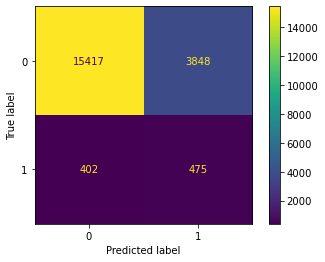

O score ROC AUC foi de 0.7658718450371566 e o Ks foi de : KstestResult(statistic=0.5728825340085394, pvalue=0.0).

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.80      0.88     19265
           1       0.11      0.54      0.18       877

    accuracy                           0.79     20142
   macro avg       0.54      0.67      0.53     20142
weighted avg       0.94      0.79      0.85     20142



In [64]:
roda_modelo(modelo_forest, df_sem_corr_nan_outlier, forest_parametros)

In [42]:
modelo_MLP = Pipeline([('sampling', SMOTE(random_state=SEED)),
                             ('Modelo', MLPClassifier(random_state=SEED))]) 

parameter_MLP = {
    'Modelo__hidden_layer_sizes': [(sp_randInt.rvs(100,600,1),sp_randInt.rvs(100,600,1),), 
                                          (sp_randInt.rvs(100,600,1),)],
    'Modelo__activation': ['tanh', 'relu', 'logistic'],
    'Modelo__solver': ['sgd', 'adam', 'lbfgs'],
    'Modelo__alpha': uniform(0.0001, 0.9),
    'Modelo__learning_rate': ['constant','adaptive']}

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Para o RandomizedSearch usando o score ROC AUC:
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Melhores parâmetros:
{'Modelo__activation': 'relu', 'Modelo__alpha': 0.05997549332453709, 'Modelo__hidden_layer_sizes': (330, 187), 'Modelo__learning_rate': 'constant', 'Modelo__solver': 'adam'}
Matriz de confusão:


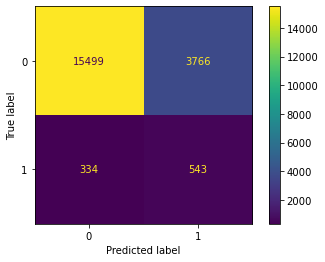

O score ROC AUC foi de 0.7862761502313794 e o Ks foi de : KstestResult(statistic=0.572286763975772, pvalue=0.0).

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     19265
           1       0.13      0.62      0.21       877

    accuracy                           0.80     20142
   macro avg       0.55      0.71      0.55     20142
weighted avg       0.94      0.80      0.85     20142

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Para o RandomizedSearch usando a precisão:
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


KeyboardInterrupt: 

In [65]:
roda_modelo(modelo_MLP, df_sem_corr_nan_outlier, parameter_MLP)

# Conclusão e previsão do Dataframe de teste

Eu tive que parar o processo de otimização do modelo MLPClassifier no meio pois estava ficando sem tempo e o processo de treino ainda demoraria mais algumas horas, assim, não obtendo a melhor paremetrização através da métrica de precisão.

Segundo esta análise o modelo mais refinado seria o MLPClassifier utilizando os parâmetros: 

{'Modelo__activation': 'relu', 'Modelo__alpha': 0.05997549332453709, 'Modelo__hidden_layer_sizes': (330, 187), 'Modelo__learning_rate': 'constant', 'Modelo__solver': 'adam'}

Assim, esse modelo que utilizarei para realizar as previsões solicitadas.

In [74]:
modelo_final = Pipeline([('sampling', SMOTE(random_state=SEED)),
                             ('Modelo', MLPClassifier(random_state=SEED, activation='relu' ,
                              alpha= 0.05997549332453709, hidden_layer_sizes = (330, 187),
                              learning_rate='constant', solver='adam'))])

In [72]:
x = df_sem_corr_nan_outlier.drop(['inadimplente'], axis=1)
y = df_sem_corr_nan_outlier['inadimplente']

In [75]:
modelo_final.fit(x,y)

Pipeline(steps=[('sampling', SMOTE(random_state=9123759)),
                ('Modelo',
                 MLPClassifier(alpha=0.05997549332453709,
                               hidden_layer_sizes=(330, 187),
                               random_state=9123759))])

In [78]:
ynew = modelo_final.predict(df_teste_sem_nan)
ynew

array([0, 1, 0, ..., 1, 0, 1])

In [83]:
df_teste_sem_nan['inadimplente'] = ynew
df_teste_sem_nan.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0,0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0,1
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0,0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0,0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0,0


In [81]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  

In [82]:
df_teste_sem_nan.to_csv('out.zip', index=False, compression=compression_opts) 